In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain, cycle
# increase width of cells. implemented for visualtions at the end of the document
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
pd.set_option('display.max_colwidth', None)

In [2]:
## Load data
dir_path = "../ml_data/ml-latest-small/"
movies_df = pd.read_csv(dir_path+'movies.csv')
tags = pd.read_csv(dir_path+'tags.csv') 
ratings = pd.read_csv(dir_path+'ratings.csv')
links = pd.read_csv(dir_path+'links.csv')
unique_user = ratings.userId.unique().tolist()

In [3]:
print("movies_df.shape: {}".format(movies_df.shape))
print("tags.shape: {}".format(tags.shape))
print("ratings.shape: {}".format(ratings.shape))
print("links.shape: {}".format(links.shape))

movies_df.shape: (9742, 3)
tags.shape: (3683, 4)
ratings.shape: (100836, 4)
links.shape: (9742, 3)


In [4]:
print("movies_df.columns: {}".format(movies_df.columns))
print("tags.columns: {}".format(tags.columns))
print("ratings.columns: {}".format(ratings.columns))
print("links.columns: {}".format(links.columns))

movies_df.columns: Index(['movieId', 'title', 'genres'], dtype='object')
tags.columns: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
ratings.columns: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links.columns: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


In [5]:
tags.describe

<bound method NDFrame.describe of       userId  movieId               tag   timestamp
0          2    60756             funny  1445714994
1          2    60756   Highly quotable  1445714996
2          2    60756      will ferrell  1445714992
3          2    89774      Boxing story  1445715207
4          2    89774               MMA  1445715200
...      ...      ...               ...         ...
3678     606     7382         for katie  1171234019
3679     606     7936           austere  1173392334
3680     610     3265            gun fu  1493843984
3681     610     3265  heroic bloodshed  1493843978
3682     610   168248  Heroic Bloodshed  1493844270

[3683 rows x 4 columns]>

In [6]:
# check for duplicates
print(movies_df.duplicated().unique())
print(tags.duplicated().unique())
print(ratings.duplicated().unique())
print(links.duplicated().unique())

[False]
[False]
[False]
[False]


# Basic EDA

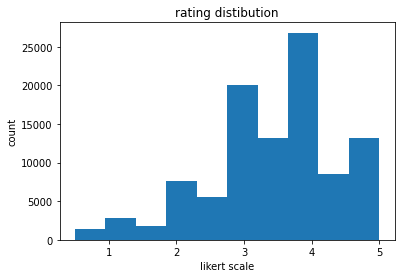

In [7]:
plt.hist(ratings.rating)
plt.title("rating distibution")
plt.ylabel("count")
plt.xlabel("likert scale")
plt.show()

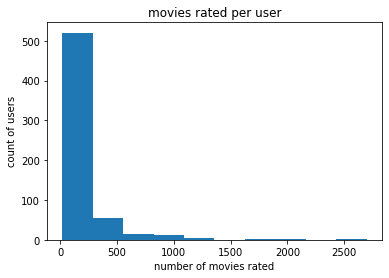

In [8]:
plt.hist(ratings.groupby("userId").count().reset_index().rating)
plt.title("movies rated per user")
plt.ylabel("count of users")
plt.xlabel("number of movies rated")
plt.show()

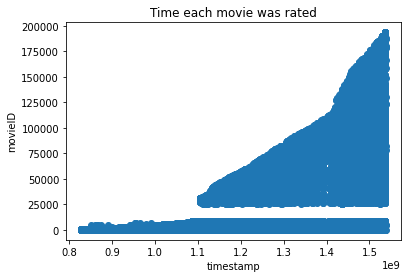

In [9]:
plt.scatter(x=ratings.timestamp, y=ratings.movieId)
plt.title("Time each movie was rated")
plt.xlabel("timestamp")
plt.ylabel("movieID")
plt.show()

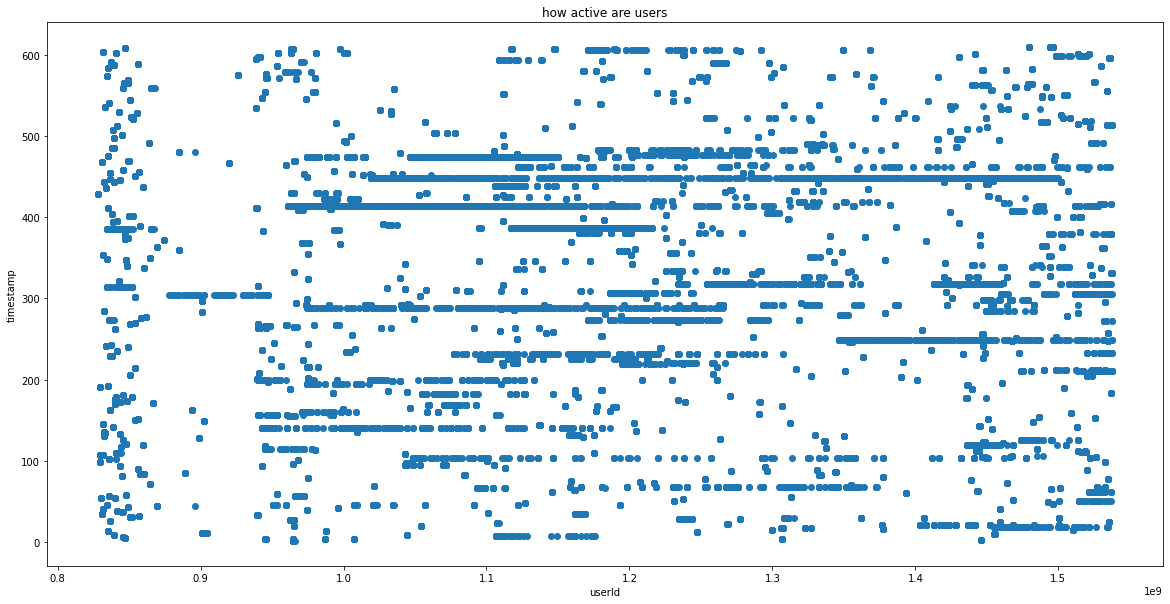

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(x=ratings.timestamp, y=ratings.userId)
plt.title("how active are users")
plt.xlabel("userId")
plt.ylabel("timestamp")
plt.show()

# Model - SVD

In [11]:
#!pip install scikit-surprise
from surprise import Dataset, Reader, SVD, accuracy, KNNBaseline
from surprise.model_selection import train_test_split, cross_validate, KFold
from surprise.model_selection.search import GridSearchCV
from surprise.prediction_algorithms.predictions import Prediction

## grid search cross validation

In [12]:
gsvc = False
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
# first entry is always the default value
param_grid = {
    'n_factors': [100, 250, 300, 350, 400], # 50, 100, 150, 200, 
    'n_epochs': [20,30,40], # 10, 15
    # 'init_mean': [],
    # 'init_std_dev': []
    'lr_all': [0.005, 0.02, 0.03],# 0.002, 0.005, 0.01, 0.5, 0.01
    'reg_all': [0.02, 0.1, 0,2] # 0.5, 0.05, 0.75, 0.15, 0.25
}
param_grid = {'n_factors': [250], 'n_epochs': [40], 'lr_all': [0.02], 'reg_all': [0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1, joblib_verbose=10, refit=True, return_train_measures=True)
gs.fit(data)
results_df = pd.DataFrame.from_dict(gs.cv_results)
display(results_df.sort_values(by=["rank_test_rmse"], axis=0, ascending=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.0s remaining:   25.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.0s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s finished


split0_test_rmse  split0_train_rmse  split1_test_rmse  split1_train_rmse  \
0          0.850367           0.484722          0.851539           0.484116   

   split2_test_rmse  split2_train_rmse  split3_test_rmse  split3_train_rmse  \
0          0.857913           0.485261          0.848644           0.484614   

   split4_test_rmse  split4_train_rmse  ...  rank_test_mae  mean_fit_time  \
0          0.843935           0.483945  ...              1      15.255397   

   std_fit_time  mean_test_time  std_test_time  \
0      0.529488        0.119005       0.005092   

                                                               params  \
0  {'n_factors': 250, 'n_epochs': 40, 'lr_all': 0.02, 'reg_all': 0.1}   

   param_n_factors  param_n_epochs  param_lr_all  param_reg_all  
0              250              40          0.02            0.1  

[1 rows x 39 columns]

In [13]:
display(results_df.sort_values(by=["rank_test_rmse"], axis=0, ascending=True)[["mean_train_rmse", "mean_train_mae", "mean_test_rmse", "mean_test_mae"]][0:9])

mean_train_rmse  mean_train_mae  mean_test_rmse  mean_test_mae
0         0.484532        0.370528         0.85048       0.651752

In [14]:
gs.predict(375, 2132)

Prediction(uid=375, iid=2132, r_ui=None, est=4.748247366360404, details={'was_impossible': False})

In [15]:
def get_top_k_for_user(userID, k, gold=False):
    """
    @param gold is used to calc the golden standard
    """
    if userID in ratings.userId.unique():
        watched_movies = ratings[ratings.userId == userID].movieId.tolist()
        unwatched_movies = movies_df[~movies_df.movieId.isin(watched_movies)].movieId.tolist()
        pred = []
        for movieID in unwatched_movies:
            pred.append(gs.predict(userID, movieID)) #algo.predict return rawIDs https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict
        if gold:
            return pd.DataFrame(pred)[["iid", "est"]].rename(columns={"iid":"movieId", "est":"{}".format(userID)})[0:k].fillna(value=0).astype({"movieId":int})
        else:
            return pd.DataFrame(pred).sort_values("est", ascending=False)[["iid", "est"]].rename(columns={"iid":"movieId", "est":"est_rating"}).reset_index(drop=True)[0:k].fillna(value=0).astype({"movieId":int})
    else:
        print("userID not in dataset")
        return None

# 9742
print(get_top_k_for_user(4, 9742, gold=True))
print(get_top_k_for_user(4, 10))
# manually inspect likert scale contribution
# a = round(get_top_k_for_user(70, len(movies_df))["est"],0)
# a.value_counts()


      movieId         4
0           1  3.816706
1           2  3.524593
2           3  2.798774
3           4  2.345492
4           5  2.816384
...       ...       ...
9521   193581  3.237007
9522   193583  3.144992
9523   193585  3.270007
9524   193587  3.256630
9525   193609  3.498898

[9526 rows x 2 columns]
   movieId  est_rating
0   132333    4.585595
1     1212    4.413337
2     3089    4.411450
3    38304    4.394082
4     7008    4.381135
5    87234    4.366551
6     8405    4.347139
7     7706    4.312186
8    27397    4.312175
9     4406    4.304562


In [16]:
# add param for seed
import random
def get_user_group(size):
    return random.sample(unique_user, size)
get_user_group(5)

[607, 332, 48, 606, 398]

In [17]:
# Config

k=10
group_score_method = "delta"
user_group=get_user_group(5)
user_group

[471, 332, 6, 157, 358]

In [18]:
top_k_per_user = {}

for user in user_group:
    top_k_per_user[user] = get_top_k_for_user(user, k)

top_k_per_user

{471:    movieId  est_rating
 0   177593    4.500344
 1     6442    4.448384
 2   132333    4.447129
 3     8477    4.446050
 4    27156    4.408979
 5   171495    4.396884
 6     2732    4.389372
 7    26326    4.387853
 8     6818    4.386407
 9    30745    4.382634,
 332:    movieId  est_rating
 0    27156    4.390394
 1     7121    4.315578
 2    43376    4.310142
 3     6442    4.297013
 4     8477    4.291675
 5   132333    4.287086
 6     6818    4.277611
 7    78836    4.263600
 8     2295    4.252064
 9     3451    4.230966,
 6:    movieId  est_rating
 0     8477    4.749684
 1   132333    4.749411
 2    43376    4.725057
 3     7121    4.723457
 4    27156    4.630638
 5    33649    4.627405
 6    77846    4.626382
 7     6818    4.625657
 8    67618    4.618482
 9    26073    4.600584,
 157:    movieId  est_rating
 0   177593    4.746799
 1     5915    4.707199
 2   132333    4.698345
 3    78836    4.689053
 4     8477    4.683620
 5     6442    4.672268
 6    40412    4.61

In [19]:
all_movies_for_group = []
for user, user_list in top_k_per_user.items():
    all_movies_for_group.append(user_list.movieId.tolist())

all_movies_for_group = list(chain(*all_movies_for_group))
print("Number of unqiue movies in this group: {}".format(len(all_movies_for_group)))
print("Unqiue movies in this group: {}".format(all_movies_for_group))

Number of unqiue movies in this group: 50
Unqiue movies in this group: [177593, 6442, 132333, 8477, 27156, 171495, 2732, 26326, 6818, 30745, 27156, 7121, 43376, 6442, 8477, 132333, 6818, 78836, 2295, 3451, 8477, 132333, 43376, 7121, 27156, 33649, 77846, 6818, 67618, 26073, 177593, 5915, 132333, 78836, 8477, 6442, 40412, 7926, 171495, 152105, 7121, 171495, 3451, 27156, 106100, 3200, 25906, 78836, 2324, 318]


# combine single User Lists to one Group List

In [31]:
def calc_group_score_for_movie(rating_dict:dict, ratings:pd.DataFrame,  meassure:str = "delta"):
    # print(rating_dict)
    group_rating = 0
    # Group Rating = mean_group_rating
    if meassure == "mean":
        group_rating = sum(rating_dict.values())/len(rating_dict.values())
    # weighted rating, giving user with more ratings a higher weight
    if meassure == "watched":
        all_ratings = len(ratings[ratings['userId'].isin(rating_dict.keys())])
        for user in rating_dict:
            group_rating += rating_dict[user] * (len(ratings[ratings['userId']== user])/all_ratings)
    # Group Rating = mean_rating (of all users in group) + mean_delta (of all users in group).
    # for user in group: user_delta = user_rating - mean_user_rating
    if meassure == "delta":
        grp_mean = ratings[ratings['userId'].isin(rating_dict.keys())]['rating'].mean()
        for user in rating_dict:
            group_rating += rating_dict[user] - ratings[ratings['userId']== user]['rating'].mean()
        group_rating = (group_rating / len(rating_dict)) + grp_mean

    # Group Rating = minimal rating in rating dict
    if meassure == "min":
        group_rating = min(rating_dict.values())
    # Check boundries
    if group_rating > 5 : group_rating = 5
    if group_rating < 0 : group_rating = 0
    return group_rating

In [21]:
def calc_group_score_for_movie_helper(row, columns:list,method:str):
    result_dict = {} 
    for column in columns:
        result_dict[column] = row[f'{column}']
    result = calc_group_score_for_movie(result_dict, ratings, method)
    return result

In [22]:
def movie_id_to_name(ids):
    if type(ids) == int:
        return movies_df.loc[movies_df.movieId == ids].title.values[0]
    if type(ids) == list:
        return movies_df.loc[movies_df.movieId.isin(ids)].title.values
#testing
print(movie_id_to_name(1))
print(movie_id_to_name([1,2]))

Toy Story (1995)
['Toy Story (1995)' 'Jumanji (1995)']


In [23]:
def get_genres_of_movie(ids):
    if type(ids) == int:
        return movies_df.loc[movies_df.movieId == ids].genres.values[0]
    if type(ids) == list:
        return movies_df.loc[movies_df.movieId.isin(ids)].genres.values
#testing
print(get_genres_of_movie(1))
print(get_genres_of_movie([1,2]))

Adventure|Animation|Children|Comedy|Fantasy
['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy']


In [35]:
# pred values for each movie for all users in the group
group_list = {}
for user, user_list in top_k_per_user.items():
    users_to_predict = list(set(user_group)-set([71]))
    for idx, movie in enumerate(user_list.movieId):
        if movie in group_list.keys():
            print("{} \talready check -> dup -> skipping".format(movie))
            continue
        ratings_of_current_movie = {user:top_k_per_user[user].est_rating[idx]}
        #ratings_of_current_movie = []

        #ratings_of_current_movie.append(top_k_per_user[user].est_rating[idx])
        for member in users_to_predict:
            ratings_of_current_movie[member] = gs.predict(member, movie).est

            #ratings_of_current_movie.append(gs.predict(member, movie).est)
        group_list[movie] = calc_group_score_for_movie(ratings_of_current_movie, ratings, group_score_method)

print("\nNumber of unique movies: {}\n".format(len(group_list)))
rec_df = pd.DataFrame(
    {"movieId":list(group_list.keys()), 
     "group_rating":list(group_list.values()),
     "movie": movie_id_to_name(list(group_list.keys())),
     "genre": get_genres_of_movie(list(group_list.keys()))
    }).sort_values("group_rating", ascending=False).reset_index(drop=True)[0:k]
rec_df

27156 	already check -> dup -> skipping
6442 	already check -> dup -> skipping
8477 	already check -> dup -> skipping
132333 	already check -> dup -> skipping
6818 	already check -> dup -> skipping
8477 	already check -> dup -> skipping
132333 	already check -> dup -> skipping
43376 	already check -> dup -> skipping
7121 	already check -> dup -> skipping
27156 	already check -> dup -> skipping
6818 	already check -> dup -> skipping
177593 	already check -> dup -> skipping
132333 	already check -> dup -> skipping
78836 	already check -> dup -> skipping
8477 	already check -> dup -> skipping
6442 	already check -> dup -> skipping
171495 	already check -> dup -> skipping
7121 	already check -> dup -> skipping
171495 	already check -> dup -> skipping
3451 	already check -> dup -> skipping
27156 	already check -> dup -> skipping
78836 	already check -> dup -> skipping

Number of unique movies: 28



movieId  group_rating                                       movie  \
0    27156      4.503672                     Last Detail, The (1973)   
1   132333      4.479352  Life Is Beautiful (La Vita è bella) (1997)   
2   177593      4.467197            Shawshank Redemption, The (1994)   
3     7121      4.466823     High and Low (Tengoku to jigoku) (1963)   
4     8477      4.462986         Jules and Jim (Jules et Jim) (1961)   
5    78836      4.452173                      Mr. Skeffington (1944)   
6   171495      4.443112         Guess Who's Coming to Dinner (1967)   
7     6442      4.409268                       Impostors, The (1998)   
8     6818      4.392995          Come and See (Idi i smotri) (1985)   
9    43376      4.369103                            Jetée, La (1962)   

                            genre  
0                    Comedy|Drama  
1        Comedy|Drama|Romance|War  
2                     Crime|Drama  
3  Crime|Drama|Film-Noir|Thriller  
4                   Drama|Romance  
5                   Drama|Romance  
6                           Drama  
7                          Comedy  
8                       Drama|War  
9                  Romance|Sci-Fi

# gold standard

In [25]:
def get_group_and_movie(df, group_size:int=5, min_movies_seen:int = 10, prints:bool=False) -> (list, str):
    # list with movies which have more than group_size scores
    list_of_possible_movies = df.groupby("movieId").count().groupby(level=0).filter(lambda x: x.userId >= group_size).reset_index().movieId.tolist()
    random_movie = random.sample(list_of_possible_movies, 1)[0]
    if prints:
        print(f"random movie id: {random_movie}")
    # all users who rated the movie
    all_user = df.loc[df.movieId == random_movie].userId.tolist()
    if prints:
        print(f"all possible users: {all_user}")
    # all users who rated more than min_movies_seen movies
    good_user = df.loc[df.userId.isin(all_user)].groupby("userId").count().groupby(level=0).filter(lambda x: x.movieId >= min_movies_seen).reset_index().userId.tolist()
    user_group = random.sample(good_user, group_size)
    if prints:
        print(f"user group: {user_group}")
    return user_group, random_movie


def goldstandard_train_test_split(user_group_movie:list, df) -> tuple:
    """
        splits the given DF into a train_df and a test_df
        gold_train -> original DF without the rating for the movies given in user_group_movie
        gold_test -> the original ratings for each user and movie given with user_group_movie
        user_group_movie -> list of tuples -> tuples must have the following sctructure (userIds:list, movieId:str)
    """
    idx_to_drop = []
    user_value = {}
    for row in user_group_movie:
        common_movie = row[1]
        user_value[common_movie] = {}
        for user in row[0]:
            movie_row = df.loc[df.userId == user].loc[df.movieId == common_movie]
            idx_to_drop.append(movie_row.index[0])
            user_value[common_movie][user] = movie_row.rating.values[0]
    return df.drop(idx_to_drop), user_value

In [37]:
"""
    models can be adujsted in the config
"""

import timeit, random
from sklearn.metrics import mean_squared_error, mean_absolute_error
tic=timeit.default_timer()

#config
gold_score_methods = ["watched", "mean", "delta", "min"]
gold_group_sizes = [2,3,5,13,21]
gold_best_model = SVD(**gs.best_params["rmse"]) 
gold_min_movies_seen=10
gold_group_nr=20
gold_prints=False

# calc gold
for gold_group_size in gold_group_sizes:
    # generate test data
    gold_user_movie_data = [get_group_and_movie(ratings, group_size=gold_group_size, min_movies_seen=gold_min_movies_seen, prints=gold_prints) for x in range(0,gold_group_nr)]
    gold_train, gold_test = goldstandard_train_test_split(gold_user_movie_data, ratings)
    if gold_prints:
        print("gold_train & gold_test created")
        
    # build model with best params and traindata from goldstandard
    gold_data = Dataset.load_from_df(gold_train[['userId','movieId','rating']], reader)
    gold_best_model.fit(gold_data.build_full_trainset())
    if gold_prints:
        print("Model trained")
        
    for gold_score in gold_score_methods:
        # calc rmse and mae
        gold_real_ratings = []
        gold_pred = []
        for gold_movie, gold_user_list in gold_test.items():
            gold_tmp_real_ratings={}
            gold_tmp_pred={}
            for gold_user, gold_rating in gold_user_list.items():
                gold_tmp_real_ratings[gold_user] = gold_rating
                gold_tmp_pred[gold_user] = gold_best_model.predict(gold_user, gold_movie).est
            gold_real_ratings.append(calc_group_score_for_movie(gold_tmp_real_ratings, ratings, gold_score))
            gold_pred.append(calc_group_score_for_movie(gold_tmp_pred, ratings, gold_score))
        print(f"Agg. method: {gold_score}")
        print(f"Group size: {gold_group_size}")
        print(f"rmse: {round(mean_squared_error(y_true=gold_real_ratings, y_pred=gold_pred), 4)}")
        print(f"mae: {round(mean_absolute_error(y_true=gold_real_ratings, y_pred=gold_pred), 4)}")
        print("--------------------------------------------")
    print("--------------------------------------------")


toc=timeit.default_timer()
print(f"Goldstandard calc time: {round(toc - tic, 2)}s") 

Agg. method: watched
Group size: 2
rmse: 0.5787
mae: 0.6314
--------------------------------------------
Agg. method: mean
Group size: 2
rmse: 0.6945
mae: 0.6354
--------------------------------------------
Agg. method: delta
Group size: 2
rmse: 0.6945
mae: 0.6354
--------------------------------------------
Agg. method: min
Group size: 2
rmse: 1.8645
mae: 1.0101
--------------------------------------------
--------------------------------------------
Agg. method: watched
Group size: 3
rmse: 0.3537
mae: 0.5051
--------------------------------------------
Agg. method: mean
Group size: 3
rmse: 0.2567
mae: 0.4189
--------------------------------------------
Agg. method: delta
Group size: 3
rmse: 0.2567
mae: 0.4189
--------------------------------------------
Agg. method: min
Group size: 3
rmse: 0.9856
mae: 0.8255
--------------------------------------------
--------------------------------------------
Agg. method: watched
Group size: 5
rmse: 0.2461
mae: 0.3644
----------------------------